In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os

In [ ]:
#Initialize Global Variables
data = []
# data_dir = '../dataset/train_data'
data_dir = 'input_images/'
le = LabelEncoder()

In [ ]:
# Tile image to hog features extraction
def extract_hog_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
    
    # Get image dimensions
    height, width = resized_image.shape
    
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    
    # Create figure for 8x8 subplot
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    fig.suptitle(f'Tiles for {file}', fontsize=16)
    # Dictionary to store features for this image
    hog_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            
            # Display tile in subplot
            axes[i, j].imshow(tile, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{i},{j}', fontsize=6)
            
            # Extract HOG features from tile
            features = hog(tile, orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        block_norm='L2-Hys')
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            hog_features[key] = features
            
            # Also append to global data list
            data.append({
                'type': 'hog',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': features
            })
    #plt.tight_layout()
    #plt.show()
    return hog_features

In [38]:
def extract_lbp_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
    # Get image dimensions
    height, width = resized_image.shape
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    # Dictionary to store features for this image
    lbp_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            # Extract LBP features from tile
            radius = 3
            n_points = 8 * radius
            lbp = local_binary_pattern(tile, n_points, radius, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, n_points + 3),
                                     range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)
            
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            lbp_features[key] = hist
            
            # Also append to global data list
            data.append({
                'type': 'lbp',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': hist
            })
    # plt.tight_layout()
    # plt.show()
    return lbp_features

In [ ]:
def write_features_to_file(filename='input_feature/input.csv'):
    # Group data by (image, tile_i, tile_j)
    grouped_data = {}
    
    for item in data:
        key = (item['image'], item['tile_i'], item['tile_j'])
        if key not in grouped_data:
            grouped_data[key] = {
                'image': item['image'],
                'tile_i': item['tile_i'],
                'tile_j': item['tile_j'],
                'hog': None,
                'lbp': None
            }
        
        # Store features by type
        grouped_data[key][item['type']] = item['features']
    
    # Create records with combined features
    records = []
    for key, tile_data in grouped_data.items():
        record = {
            'image': tile_data['image'],
            'tile_i': tile_data['tile_i'],
            'tile_j': tile_data['tile_j']
        }
        
        # Add HOG features
        if tile_data['hog'] is not None:
            for idx, val in enumerate(tile_data['hog']):
                record[f'x_hog_{idx}'] = val
        
        # Add LBP features
        if tile_data['lbp'] is not None:
            for idx, val in enumerate(tile_data['lbp']):
                record[f'x_lbp_{idx}'] = val
        
        records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(records)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    
    print(f'Saved {len(df)} records to {filename}')
    print(f'Shape: {df.shape}')
    print(f'Columns: {df.columns[:10].tolist()}...')  # Show first 10 columns

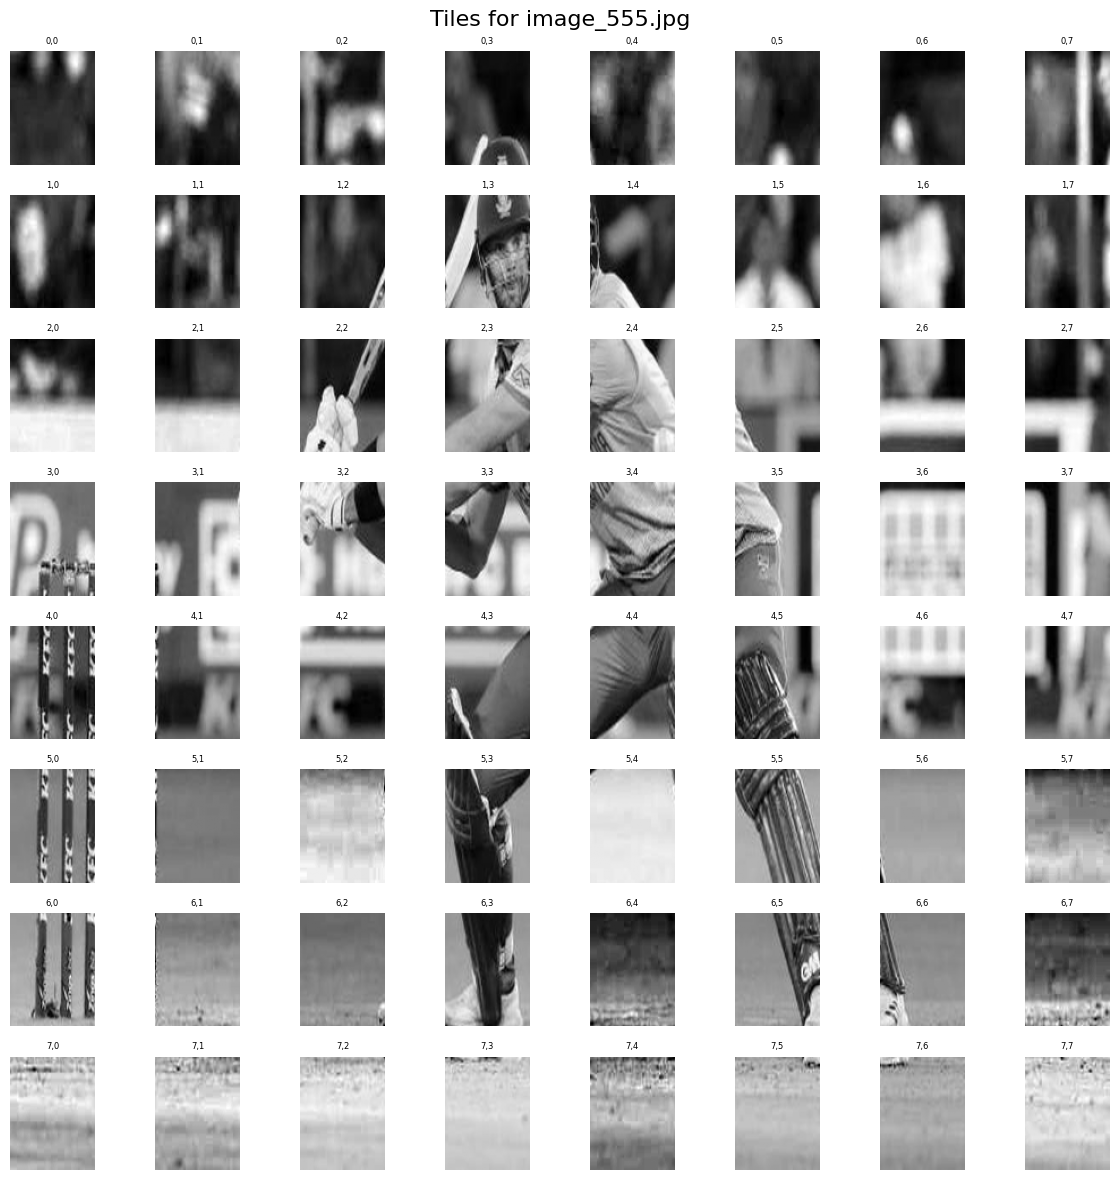

Extracted HOG features for image_555.jpg, total tiles: 64 and size of each tile feature vector: 3168


i:\Test\pml-project\final-env\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features for image_555.jpg, total tiles: 64 and size of each tile feature vector: 26
Saved 64 records to features_data_testing_555.csv
Shape: (64, 3197)
Columns: ['image', 'tile_i', 'tile_j', 'x_hog_0', 'x_hog_1', 'x_hog_2', 'x_hog_3', 'x_hog_4', 'x_hog_5', 'x_hog_6']...


In [40]:
#Run the extraction
for file in os.listdir(data_dir):
    # Skip if it's a directory or not an image file
    if os.path.isdir(os.path.join(data_dir, file)) or not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        continue
    hog_features = extract_hog_features(file)
    print(f'Extracted HOG features for {file}, total tiles: {len(hog_features)} and size of each tile feature vector: {len(next(iter(hog_features.values())))}')
    lbp_features = extract_lbp_features(file)
    print(f'Extracted LBP features for {file}, total tiles: {len(lbp_features)} and size of each tile feature vector: {len(next(iter(lbp_features.values())))}')
    #color_histogram_features = extract_color_histogram_features(file)
    #print(f'Extracted Color Histogram features for {file}, total tiles: {len(color_histogram_features)} and size of each tile feature vector: {len(next(iter(color_histogram_features.values())))}')
    write_features_to_file()

In [41]:
# # Read data from features_data_grp_1.csv
# import pandas as pd
# df_labelled = pd.read_csv('../outputs/features_data_labelled.csv')

# # print(df.head())
# print(df_labelled.shape)

# #drop columns image, tile_i, tile_j
# df_features = df_labelled.drop(columns=['image', 'tile_i', 'tile_j','y'])

# # find out correlations coefficients of all features with each other
# correlation_matrix = df_features.corr()

# #find out features which have correlation coefficient > 0.90 with each other
# high_correlation_pairs = []
# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.90:
#             high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
# print(f'Number of highly correlated feature pairs (>0.90): {len(high_correlation_pairs)}')
# #print first 10 highly correlated feature pairs
# for pair in high_correlation_pairs[:10]:
#     print(pair)

# # find unique features from the highly correlated pairs
# unique_features_to_drop = set()
# for feat1, feat2, corr in high_correlation_pairs:
#     unique_features_to_drop.add(feat2)  # arbitrarily drop the second feature in the pair
# print(f'Number of unique features to drop due to high correlation: {len(unique_features_to_drop)}')

# #drop these features from df_features
# df_reduced = df_labelled.drop(columns=list(unique_features_to_drop))
# print(f'Shape of features after dropping highly correlated ones: {df_reduced.shape}')

# #create csv of reduced features
# df_reduced.to_csv('../outputs/features_data_reduced.csv', index=False)